In [136]:
import numpy as np

import pandas as pd

import math

from pathlib import Path

import random

import matplotlib.pyplot as plt 

from matplotlib.ticker import PercentFormatter

path_data = Path.cwd().parent / 'data'

from collections import OrderedDict

In [137]:
n_session_sites = 1
vaccine_volume = 5 #mL
session_frequency = 28 #days
min_stock_s = 20 #days of stock
max_stock_S = 50 #days of stock
lead_time = 15 #days
phc_replenishment_frequency = 28 #days

session_disruption = 0.0 #percent disrupted (0-1)
phc_replenishment_disruption = 0.1 #percent disrupted (0-1)

unserved_dropout = False

inventory_policy = "Reorder point" # Fixed period ordering/Reorder point

In [138]:
actual_session_site = np.zeros(365) # Actual vaccination date at session site
actual_session_site[0] = -1
actual_phc = np.zeros(365) # Actual vaccination date at PHC

demand_real_session_site = np.zeros(365)
demand_served_session_site = np.zeros(365)
demand_unserved_session_site = np.zeros(365)

demand_real_phc = np.ones(365)
demand_served_phc = np.zeros(365)
demand_unserved_phc = np.zeros(365)

demand_real_phc[0] = 0
starting_capacity = np.zeros(365)
starting_capacity[0] = max_stock_S
starting_capacity[1] = max_stock_S

df = pd.DataFrame({'Starting Capacity':[], 'Vaccination Session Site':[], 'Delay Session Site':[], 'Vaccination PHC':[], 'Delay PHC':[], 'Demand Real Session Site':[],
                   'Demand Served Session Site':[], 'Demand Unserved Session Site':[], 'Demand Real PHC': [],
                   'Demand Served PHC': [], 'Demand Unserved PHC': []})

In [139]:
prevsession_session_site = 0
prevsession_phc = 1
unfulfilled_pool_phc = 0
waiting_for_replenishment = False
t_0 = 1000

for today in range(1,364):
    
    if (today+7)%session_frequency==0:
        print(f"Today is session day {today}")
        for birthday, vacday in enumerate(actual_session_site):
            last_served_birth = np.max(np.where(actual_session_site == prevsession_session_site))
            if unserved_dropout:
                if (birthday<=today) & (actual_session_site[birthday]==0) & (birthday-last_served_birth<starting_capacity[today-1]):
                    actual_session_site[birthday] = today
                elif (birthday<=today) & (actual_session_site[birthday]==0) & (birthday-last_served_birth>=starting_capacity[today-1]):
                    actual_session_site[birthday] = -1
            else:
                if (birthday<=today) & (actual_session_site[birthday]==0) & (birthday-last_served_birth<starting_capacity[today-1]):
                    actual_session_site[birthday] = today
        demand_real_session_site[today] = today - prevsession_session_site
        demand_served_session_site[today] =  np.sum(actual_session_site==today)
        demand_unserved_session_site[today] = demand_real_session_site[today] - demand_served_session_site[today]
        prevsession_session_site = today
    else:
        demand_real_session_site[today] = 0
        demand_served_session_site[today] =  0
        demand_unserved_session_site[today] = 0

#     demand_real_phc[today] = 1
    if inventory_policy == "Fixed period ordering":
        if (today%phc_replenishment_frequency==0) & (random.random() > phc_replenishment_disruption):
            starting_capacity[today] = max_stock_S - demand_real_phc[today-1] - unfulfilled_pool_phc - demand_served_session_site[today-1]
            print(f"today is replensihment day: {today}")
            print(f"starting capacity today is {starting_capacity[today]}")

        else:
            starting_capacity[today] = starting_capacity[today-1] - demand_real_phc[today-1] - unfulfilled_pool_phc - demand_served_session_site[today-1]
            print(f"today is: {today}")
            print(f"starting capacity today is {starting_capacity[today]}")
    
    else:
        if (starting_capacity[today-1] < min_stock_s) & ~(waiting_for_replenishment):
            waiting_for_replenishment = True
            t_0 = today
            
        if today - t_0 == lead_time:
            starting_capacity[today] = max_stock_S - demand_real_phc[today-1] - unfulfilled_pool_phc - demand_served_session_site[today-1]
            waiting_for_replenishment = False
        else:
            starting_capacity[today] = starting_capacity[today-1] - demand_real_phc[today-1] - unfulfilled_pool_phc - demand_served_session_site[today-1]
    
    
    if unserved_dropout:
        if starting_capacity[today]<0:
            demand_served_phc[today-1] = 0
            demand_unserved_phc[today-1] = 1
            starting_capacity[today] = 0
            actual_phc[today] = -1
        else:
            demand_served_phc[today-1] = 1
            demand_unserved_phc[today-1] = 0
            actual_phc[today] = today
    else:
        if starting_capacity[today]<0:
            demand_served_phc[today-1] = 0
            demand_unserved_phc[today-1] = 1
            unfulfilled_pool_phc += 1
            starting_capacity[today] = 0
        else:
            demand_served_phc[today-1] = 1 + unfulfilled_pool_phc
            demand_unserved_phc[today-1] = 0
            unfulfilled_pool_phc = 0
            for birthday, vacday in enumerate(actual_phc):
                if (birthday<=today) & (actual_phc[birthday]==0):
                    actual_phc[birthday] = today

    

Today is session day 21
Today is session day 49
Today is session day 77
Today is session day 105
Today is session day 133
Today is session day 161
Today is session day 189
Today is session day 217
Today is session day 245
Today is session day 273
Today is session day 301
Today is session day 329
Today is session day 357


In [140]:
df['Starting Capacity'] = starting_capacity
df['Vaccination Session Site'] = actual_session_site
df['Vaccination PHC'] = actual_phc
df['Demand Real Session Site'] = demand_real_session_site
df['Demand Served Session Site'] = demand_served_session_site
df['Demand Unserved Session Site'] = demand_unserved_session_site
df['Demand Real PHC'] = demand_real_phc
df['Demand Served PHC'] = demand_served_phc
df['Demand Unserved PHC'] = demand_unserved_phc

df = df.reset_index()
df['Should be session day'] = df['index'].apply(lambda x: math.ceil((x+7)/28)*28-7)
df['Delay Session Site'] = df['Vaccination Session Site'] - df['Should be session day']
df['Delay Session Site'] = df['Delay Session Site'].clip(-1)

df['Delay PHC'] = df['Vaccination PHC'] - df['index']
df['Delay PHC'] = df['Delay PHC'].clip(-1)

unserved_dropout_label = "Demand Lost" if unserved_dropout else "Demand Backlogged"

# df.to_csv(path_data / f'11 Supply Model - {inventory_policy} - {unserved_dropout_label}.csv', index = False)

In [141]:
df = df[(df['index']>0)&(df['index']<358)]

data_session_site_delay = df.loc[df['Delay Session Site']>=0,'Delay Session Site']
data_phc_delay = df.loc[df['Delay PHC']>=0,'Delay PHC']

figtxt=f"Session Frequency = {session_frequency} #days\n \
Session Disruption = {session_disruption} #percent disrupted (0-1) \n \
Min stock (s) = {min_stock_s} #days of stock \n \
Max stock (S) = {max_stock_S} #days of stock \n \
Lead time = {lead_time} #days \n \
Replenishment Frequency at PHC = {phc_replenishment_frequency} #days \n \
Replenishment Disruption at PHC = {phc_replenishment_disruption} #percent disrupted (0-1)"


plt.clf()
fig, ax = plt.subplot_mosaic(
    [["top row", "top row"],
     ["bottom left", "bottom right"]], figsize=(12,8)
)
# fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(12,8))
plt.subplots_adjust(wspace=0.5, hspace=0.4)

ax["top row"].plot(df['index'], df['Starting Capacity'])
ax["top row"].set_xlabel('Day')
ax["top row"].set_ylabel('Remaining Capacity')
ax["top row"].set_title(f'Remaining capacity at PHC - {inventory_policy} - {unserved_dropout_label}')

ax["bottom right"].hist(data_session_site_delay, weights=np.ones(len(data_session_site_delay)) / len(data_session_site_delay), bins =20)
ax["bottom right"].set_xlabel('Delay in days')
ax["bottom right"].set_ylabel(f'Percentage of observations')
ax["bottom right"].set_title(f'Session site delay - {inventory_policy} - {unserved_dropout_label}')
ax["bottom right"].set_xlim([0,None])
ax["bottom right"].yaxis.set_major_formatter(PercentFormatter(1))

ax["bottom left"].hist(data_phc_delay, weights=np.ones(len(data_phc_delay)) / len(data_phc_delay), bins =20)
ax["bottom left"].set_xlabel('Delay in days')
ax["bottom left"].set_ylabel(f'Percentage of observations')
ax["bottom left"].set_title(f'PHC delay - {inventory_policy} - {unserved_dropout_label}')
ax["bottom left"].set_xlim([0, None])
ax["bottom left"].yaxis.set_major_formatter(PercentFormatter(1))

plt.figtext(0.5, -0.1 , figtxt, wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(path_data / 'Supply Model Plots' / f'{inventory_policy} - {unserved_dropout_label}2.jpg', bbox_inches='tight')
# plt.show()
print("Done")

Done


<Figure size 432x288 with 0 Axes>

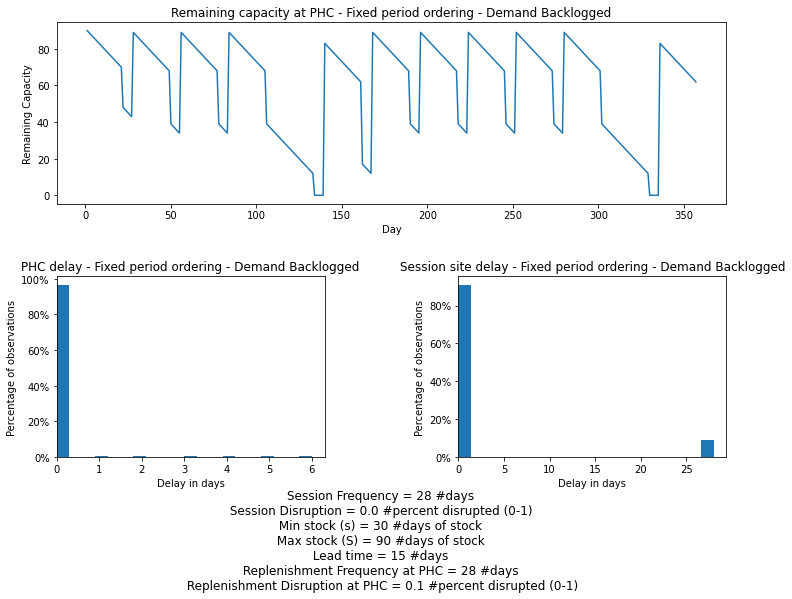

In [132]:
plt.show()

In [134]:
plt.savefig(path_data / 'Supply Model Plots' / f'{inventory_policy} - {unserved_dropout_label}2.jpg', bbox_inches='tight')

### Old logic

In [53]:
annual_births_session_site = random.sample(range(100, 500), n_session_sites)
annual_births_phc = random.sample(range(100, 500), 1)

In [59]:
births_array_session_site

array([2, 1, 0, 2, 0, 0, 1, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 2, 0, 3, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,

In [58]:
pois = lambda x: np.random.poisson(x/365, 365)

births_array_session_site = np.array(list(map(pois, annual_births_session_site)))[0]
births_array_phc = np.array(list(map(pois, annual_births_phc)))[0]

In [5]:
demand_session_site = births_array_session_site * vaccine_volume
demand_phc = births_array_phc * vaccine_volume
demand_total = demand_phc + demand_session_site.sum(axis = 0)

annual_vaccine_volume = (births_array_phc.sum() + births_array_session_site.sum())*vaccine_volume

In [6]:
print(f"Demand by session site: {demand_session_site.sum(axis = 1)}")

Demand by session site: [945 915 490 980]


In [31]:
min_stock_s = int(annual_vaccine_volume/12*min_stock_level)
max_stock_S = int(annual_vaccine_volume/12*max_stock_level)
capacity_coldbox = int(annual_vaccine_volume/12)

In [8]:
print(f"(s,S):{min_stock_s,max_stock_S}")

(s,S):(226, 678)


In [9]:
sessions = np.zeros((n_session_sites, 365))

In [10]:
365//28+1

14

In [11]:
for i in range(n_session_sites):
    session_date = [i for i in range(i*7,365,session_frequency)]
    sessions[i,:].put(session_date, 1)

### Reorder point (s,S)

In [ ]:
demand_fulfilled_session_site = 

In [12]:
def reorder_point(min_stock_s, max_stock_S, lead_time, demand_today, capacity_prevday, day, waiting_for_replenishment, t_0):
    unfulfilled_demand_today = 0
    if (capacity_prevday < min_stock_s) & ~(waiting_for_replenishment):
        waiting_for_replenishment = True
        t_0 = day
    if day - t_0 == lead_time:
        capacity_today = max_stock_S - demand_today
        waiting_for_replenishment = False
    else:
        capacity_today = capacity_prevday - demand_today
        if capacity_today<0:
            unfulfilled_demand_today = -capacity_today
            capacity_today = 0
    fulfilled_demand_today = demand_today - unfulfilled_demand_today
    return capacity_today, fulfilled_demand_today, unfulfilled_demand_today, waiting_for_replenishment, t_0

In [44]:
def fixed_period_ordering(demand_prevday, capacity_prevday, day, t_0):
    unfulfilled_demand_prevday = 0
    if day - 1 - t_0 == phc_replenishment_frequency:
        print("Replenishment yesterday")
        print(day)
        capacity_today = max_stock_S - demand_prevday
        t_0 = day - 1
    else:
        capacity_today = capacity_prevday - demand_prevday
    if capacity_today<0:
        unfulfilled_demand_prevday = -capacity_prevday
        capacity_today = 0
    fulfilled_demand_prevday = demand_prevday - unfulfilled_demand_prevday
    return capacity_today, fulfilled_demand_prevday, unfulfilled_demand_prevday, t_0

In [48]:
prev_session_index = np.zeros((n_session_sites,int(np.max(sessions.sum(axis=1)))))
demand_session_sites_actual = np.zeros((n_session_sites,365))
demand_total_actual = np.zeros(365)
remaining_capacity_phc = np.zeros(365)

delay_matrix = np.zeros((n_session_sites,365))

remaining_capacity = np.zeros(365)

remaining_capacity[0] = max_stock_S #Start with full stock

waiting_for_replenishment = False

demand_unfulfilled = np.zeros(365)

demand_fulfilled = np.zeros(365)

if inventory_policy == "Fixed period ordering":
    t_0 = 0 
else:
    t_0 = 1000

for day in range(1,365):
    for session_site in range(n_session_sites):
        previous_session = int(np.max(prev_session_index[session_site,:]))
        if 365-previous_session>session_frequency:
            delay_matrix[session_site,previous_session:day] += 1
        else:
            #Last session
            next
        if (day+session_site*7)%session_frequency==0:
            if random.random()<session_disruption:
                # Session disrupted
                if unserved_dropout:
                    prev_session_index[session_site,np.argmax(prev_session_index[session_site,:])+1] = day
                else:
                    next
            else:
                demand_session_sites_actual[session_site, day] = sum(demand_session_site[session_site, previous_session:day])
                prev_session_index[session_site,np.argmax(prev_session_index[session_site,:])+1] = day
                
    demand_total_actual[day] = demand_phc[day] + sum(demand_session_sites_actual[:,day])
    
    if inventory_policy == "Fixed period ordering":
        remaining_capacity[day], demand_fulfilled[day], demand_unfulfilled[day], t_0 = fixed_period_ordering(demand_total_actual[day-1], remaining_capacity[day-1], day, t_0)
    else:
        remaining_capacity[day], demand_unfulfilled[day], waiting_for_replenishment, t_0 = reorder_point(min_stock_s, max_stock_S, lead_time, 
                                                                     demand_total_actual[day], remaining_capacity[day-1], day,
                                                                     waiting_for_replenishment, t_0)
    
    

Replenishment yesterday
29
Replenishment yesterday
57
Replenishment yesterday
85
Replenishment yesterday
113
Replenishment yesterday
141
Replenishment yesterday
169
Replenishment yesterday
197
Replenishment yesterday
225
Replenishment yesterday
253
Replenishment yesterday
281
Replenishment yesterday
309
Replenishment yesterday
337


In [49]:
remaining_capacity

array([678., 678., 678., 673., 663., 658., 648., 643., 623., 623., 623.,
       608., 608., 603., 603., 573., 558., 548., 548., 548., 548., 533.,
       468., 468., 453., 443., 438., 438., 438., 608., 598., 593., 588.,
       573., 573., 573., 523., 523., 518., 513., 508., 508., 503., 458.,
       448., 448., 448., 448., 443., 443., 333., 333., 323., 318., 308.,
       308., 308., 638., 638., 633., 623., 613., 603., 603., 533., 528.,
       518., 513., 513., 498., 493., 458., 458., 453., 428., 423., 423.,
       413., 353., 343., 333., 333., 318., 303., 303., 628., 613., 598.,
       593., 588., 583., 583., 503., 498., 498., 498., 493., 488., 478.,
       423., 423., 413., 403., 393., 393., 393., 293., 288., 283., 273.,
       273., 268., 263., 603., 603., 593., 578., 568., 543., 543., 408.,
       398., 383., 378., 373., 368., 368., 338., 333., 333., 328., 323.,
       318., 318., 253., 253., 248., 243., 238., 233., 223., 593., 583.,
       583., 578., 568., 553., 553., 498., 488., 48

In [71]:
unique, counts = np.unique(delay_matrix[2,:], return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 0. 15.]
 [ 1. 13.]
 [ 2. 13.]
 [ 3. 13.]
 [ 4. 13.]
 [ 5. 13.]
 [ 6. 13.]
 [ 7. 13.]
 [ 8. 13.]
 [ 9. 13.]
 [10. 13.]
 [11. 13.]
 [12. 13.]
 [13. 13.]
 [14. 13.]
 [15. 12.]
 [16. 12.]
 [17. 12.]
 [18. 12.]
 [19. 12.]
 [20. 12.]
 [21. 12.]
 [22. 12.]
 [23. 12.]
 [24. 12.]
 [25. 12.]
 [26. 12.]
 [27. 12.]
 [28. 12.]]


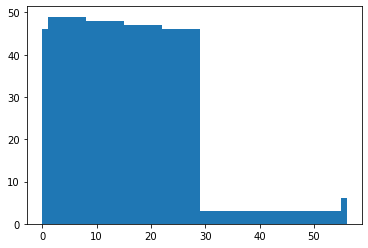

In [66]:
plt.hist(delay_matrix.flatten(), bins = 56)
plt.show()

In [48]:
remaining_capacity

array([1126., 1116., 1111., 1111., 1106., 1106., 1101., 1061., 1051.,
       1046., 1041., 1041., 1041., 1041.,  966.,  966.,  956.,  946.,
        946.,  941.,  941.,  831.,  821.,  816.,  811.,  811.,  811.,
        801.,  736.,  726.,  726.,  726.,  726.,  726.,  721.,  511.,
        506.,  501.,  501.,  496.,  496.,  496.,  386.,  376.,  366.,
        361.,  356.,  351.,  346.,  136.,  131.,  116.,  111.,  106.,
         96.,   86., 1086., 1076., 1076., 1071., 1061., 1061., 1056.,
        861.,  861.,  851.,  846.,  846.,  846.,  836.,  681.,  676.,
        666.,  656.,  656.,  646.,  636.,  431.,  431.,  431.,  426.,
        421.,  411.,  411.,  331.,  321.,  321.,  306.,  301.,  301.,
        291.,   91.,   76.,   66.,   66.,   61.,   51.,   51.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0., 1056., 1051., 1041., 1041., 1041.,
       1036., 1031.,  841.,  836.,  836.,  836.,  836.,  831.,  831.,
        626.,  621.,

In [ ]:
session_volume = np.zeros((n_session_sites,int(np.max(sessions.sum(axis=1)))))

In [ ]:
for session_site in range(n_session_sites):
    session_volume[session_site,:] = [sum(demand_session_site[session_site, np.max((i-session_frequency,0)):i]) for i in range(session_site*7,365,session_frequency)]


In [ ]:
[i for i in range(0*7,365,session_frequency)]